<a href="https://colab.research.google.com/github/ncpitrsb/Aspect-based-Sentiment-Analysis-with-BERT/blob/main/Contest1%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup + Load Data


In [ ]:
!pip install tokenizers

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import spacy
from gensim.test.utils import datapath
from gensim.models import word2vec, KeyedVectors
import nltk
from nltk.tokenize import word_tokenize
import os
import pickle as pkl
import gzip
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
configuration = BertConfig(num_hidden_layers=2,num_attention_heads=4)

In [ ]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
!gdown --id 1s-8A8sF7b23Tb9Myoc_3DTl6YXLpL17L

Downloading...
From: https://drive.google.com/uc?id=1s-8A8sF7b23Tb9Myoc_3DTl6YXLpL17L
To: /content/lab4_train.csv
100% 331k/331k [00:00<00:00, 51.2MB/s]


In [ ]:
!gdown --id 1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_

Downloading...
From: https://drive.google.com/uc?id=1YtAHCzeZUXGZQ9cimdkkUq4lUk3ZH-I_
To: /content/evaluate.py
100% 7.03k/7.03k [00:00<00:00, 5.94MB/s]


In [ ]:
df=pd.read_csv("lab4_train.csv")
df = df[['text','polarity']]

In [ ]:
def tumLower(t):
    return t.lower()

In [ ]:
df['text'] = df['text'].apply(tumLower)

In [ ]:
df

,text,polarity
0,but the staff was so horrible to us.,negative
1,"to be completely fair, the only redeeming fact...",positive
2,"to be completely fair, the only redeeming fact...",negative
3,"the food is uniformly exceptional, with a very...",positive
4,where gabriela personaly greets you and recomm...,positive
...,...,...
3151,i would highly recommend this place to everyon...,positive
3152,the service is fantastic.,positive
3153,i recommend that you try this hidden spot whic...,positive
3154,the garlic mashed potatoes are hands down the ...,positive


In [ ]:
np.random.seed(42)

In [ ]:
def StratifiedSplit(dat,label_name,split_ratio):
  total_row=dat.count()[0]
  labels=dat[label_name].unique()
  ratio_dict={}
  for i in labels:
    ratio_dict[i]=dat.where(dat[label_name]==i).dropna().count()[0]/total_row
  num_sample=int(total_row*split_ratio)
  test_df=pd.DataFrame(columns=dat.columns)
  train_df=pd.DataFrame(columns=dat.columns)
  for i in labels:
    num_sample_label =int(num_sample*ratio_dict[i])
    dat_sm=dat.where(dat[label_name]==i).dropna()
    dat_sm=dat_sm.sample(frac=1)
    msk = np.random.rand(dat_sm.count()[0]) < (num_sample_label/dat_sm.count()[0])
    test_df=test_df.append(dat_sm[msk])
    train_df=train_df.append(dat_sm[~msk])
  return (train_df, test_df)

In [ ]:
df.polarity.describe()

count         3156
unique           4
top       positive
freq          1876
Name: polarity, dtype: object

In [ ]:
df['polarity'].unique()

array(['negative', 'positive', 'neutral', 'conflict'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3156 non-null   object
 1   polarity  3156 non-null   object
dtypes: object(2)
memory usage: 49.4+ KB


In [ ]:
max_seq=79
min_seq=2

In [ ]:
def splitSentiment(x):
  if x=='negative':
    return 0
  elif x=='neutral':
    return 1
  elif x=='positive':
    return 2
  elif x=='conflict':
    return 3

In [ ]:
df=df[(df['text'].apply(lambda x: x.split()).apply(lambda x:len(x))<max_seq) & (df['text'].apply(lambda x: x.split()).apply(lambda x:len(x))>min_seq)]

In [ ]:
df

,text,polarity
0,but the staff was so horrible to us.,negative
1,"to be completely fair, the only redeeming fact...",positive
2,"to be completely fair, the only redeeming fact...",negative
3,"the food is uniformly exceptional, with a very...",positive
4,where gabriela personaly greets you and recomm...,positive
...,...,...
3151,i would highly recommend this place to everyon...,positive
3152,the service is fantastic.,positive
3153,i recommend that you try this hidden spot whic...,positive
3154,the garlic mashed potatoes are hands down the ...,positive


In [ ]:
df['polarity'] = df['polarity'].apply(splitSentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


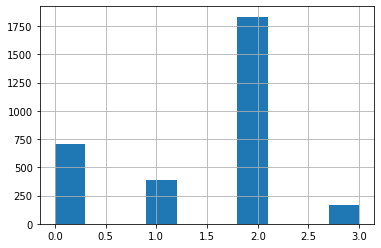

In [ ]:
df["polarity"].hist()

In [ ]:
train_, test_=StratifiedSplit(df,"polarity",0.2)

In [ ]:
### LOAD BERT TOKENIZERS ###
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

In [ ]:
x_ids_tr=[tokenizer.encode(i).ids for i in train_["text"]]
x_ids_tr=pad_sequences(x_ids_tr,maxlen=max_seq,padding="post")
x_msk_tr=[tokenizer.encode(i).attention_mask for i in train_["text"]]
x_msk_tr=pad_sequences(x_msk_tr,maxlen=max_seq,padding="post")
y_tr=to_categorical(train_["polarity"].values)

In [ ]:
train_["polarity"]

2133    0.0
396     0.0
365     0.0
986     0.0
1452    0.0
       ... 
1729    3.0
2505    3.0
103     3.0
1798    3.0
232     3.0
Name: polarity, Length: 2496, dtype: float64

In [ ]:
x_ids_t=[tokenizer.encode(i).ids for i in test_["text"]]
x_ids_t=pad_sequences(x_ids_t,maxlen=max_seq,padding="post")
x_msk_t=[tokenizer.encode(i).attention_mask for i in test_["text"]]
x_msk_t=pad_sequences(x_msk_t,maxlen=max_seq,padding="post")
y_t=to_categorical(test_["polarity"].values)

In [ ]:
import csv
import sys
import cv2
import os
import random
import re
import nltk
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,Embedding,LSTM
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.layers import Embedding

tf.test.gpu_device_name()

''

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#Bert
max_length = 79
all_ins = Input(shape = (3,max_length,), dtype=tf.int32)
ids = all_ins[:,0,:]
att =  all_ins[:,1,:]
tok =  all_ins[:,2,:]
## CLS=1 All word emb=0
wrd_embedding = encoder(input_ids, attention_mask=attn_mask)[0]
#bert = TFBertModel.from_pretrained('bert-base-uncased')([ids,att,tok]) 
lstmlayer=LSTM(128,input_shape=(35,768), return_sequences=True)(wrd_embedding)

conv1=Conv1D(64,(3),padding='same',activation='relu')(lstmlayer)
drop1=Dropout(0.5)(conv1)
conv2=Conv1D(32,(3),padding='same',activation='relu')(drop1)
drop2=Dropout(0.5)(conv2)
conv3=Conv1D(16,(3),padding='same',activation='relu')(drop2)
classifier = Dense(3, activation='softmax')(conv3)
bert = TFBertModel.from_pretrained('/kaggle/input/bert-base-uncased/bert-base-uncased-tf_model.h5',config=config)([ids,att,tok])
model = Model(all_ins, outputs=classifier)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[metric])
model.summary()


In [ ]:
!pip install '/kaggle/input/transformerswhlfiles/transformers-2.11.0-py3-none-any.whl'

Processing /kaggle/input/transformerswhlfiles/transformers-2.11.0-py3-none-any.whl
ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: '/kaggle/input/transformerswhlfiles/transformers-2.11.0-py3-none-any.whl'



In [ ]:
bert_history = model.fit(ds_train_encoded,y_tr,batch_size=128,epochs=6)

NameError: ignored

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=3,
        verbose=1,
    )
]

In [ ]:
model=tf.keras.Model(inputs=[input_ids,attn_mask] ,outputs=classifier)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 79)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 79)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 79, 128)      459264      tf_bert_model[4][0]        

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

In [ ]:
# history = model.fit(x=[x_ids_tr,x_msk_tr],y=y_tr, batch_size=128, epochs=30, validation_data=([x_ids_t,x_msk_t],y_t))
history=model.fit(x=[x_ids_tr,x_msk_tr],y=y_tr,epochs=10,validation_data=([x_ids_t,x_msk_t],y_t),verbose=1,batch_size=64,callbacks=callbacks)

Epoch 1/10


ValueError: ignored